In [1]:
import os

# Manually force the correct proj data path
os.environ["PROJ_LIB"] = "/home/kwameatt/anaconda3/envs/cs231n/share/proj"

# Patch pyproj's internal config path to use correct one
import pyproj
pyproj.datadir.set_data_dir("/home/kwameatt/anaconda3/envs/cs231n/share/proj")

import geopandas as gpd

gdf = gpd.GeoDataFrame(
    {"LON": [10], "LAT": [50]},
    geometry=gpd.points_from_xy([10], [50]),
    crs="EPSG:4326"
)

print("Success! CRS is:", gdf.crs)


/home/kwameatt/anaconda3/envs/cs231n/lib/python3.7/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


Success! CRS is: EPSG:4326


In [2]:
#hopefully this will fix the CRS import problem PERMANENTLY
%run pyproj_fix.py

In [3]:
from __future__ import division
import numpy as np
import pickle
import torch, random, copy
import torch.optim as optim
from torch import nn
from sh_utils import *
from basic_structure import IGNNK, IGNNK_ModOptionB
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import pandas as pd
import re
from shapely.geometry import Point, LineString
from geopy.distance import geodesic
import geopandas as gpd
from datetime import datetime

import matplotlib.pyplot as plt

In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # if using GPU
    torch.cuda.manual_seed_all(seed)  # for multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)  # raises error for non-deterministic ops


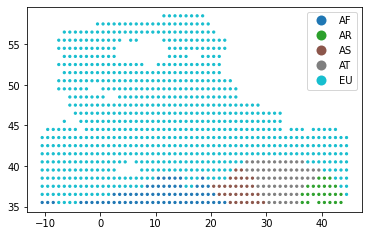

In [5]:
set_seed(42)

# Load training data = Anchor + grid nodes
grid_gdf_path = "/mnt/e/GNN_paper/2025_IGNNK/data/grids_train/all_grid_data_1p0r.csv"
anchor_data_path = "/mnt/e/GNN_paper/2025_IGNNK/data/anchors_train/WSM2025_EU.csv"

#generate, clean, and process data, then construct the graph adjacency and feature matrix 
sh_dat = generate_shmax_train_data(anchor_data_path, grid_gdf_path)
A, X_target, grid_gdf, anchor_gdf, test_anchor_data, node_info = load_shmax_train_data()

df_cols = ['ID', 'LON', 'LAT', 'DIST', 'PLATE', 'QUALITY', 'REGIME_1', 'AZI', 'geometry']
grid_gdf = grid_gdf[df_cols] 
anchor_gdf = anchor_gdf[df_cols]
node_info = node_info[df_cols]
test_anchor_data = test_anchor_data[df_cols]

# plates_gdf.boundary.plot(edgecolor='black')
grid_gdf.plot(column='PLATE', markersize=5, legend=True)
# grid_gdf.plot(column='BOUNDARY', markersize=5, legend=True)
plt.show()

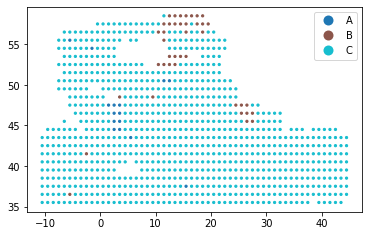

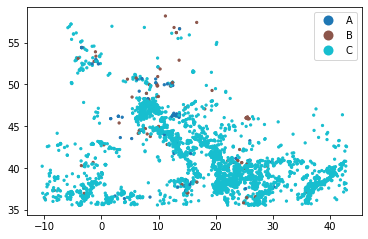

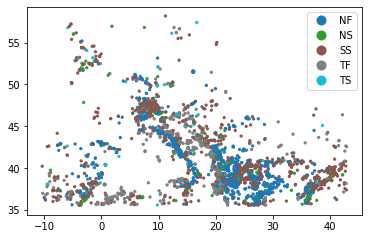

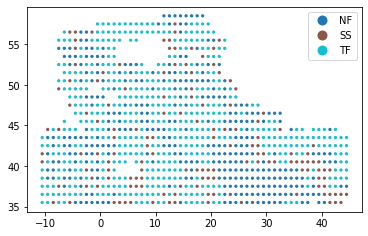

In [7]:
grid_gdf.shape
grid_gdf.plot(column='QUALITY', markersize=5, legend=True)
anchor_gdf.plot(column='QUALITY', markersize=5, legend=True)
anchor_gdf.plot(column='REGIME_1', markersize=5, legend=True)
grid_gdf.plot(column='REGIME_1', markersize=5, legend=True)
plt.show()

In [6]:
# anchor_gdf = anchor_gdf[~(anchor_gdf["REGIME"] == 'U')]

In [6]:
anchor_gdf

,ID,LON,LAT,DIST,PLATE,QUALITY,REGIME_1,AZI,geometry
0,wsm00016,29.100,40.180,57.0,AT,B,NF,0.0,POINT (29.10000 40.18000)
1,wsm00017,33.690,41.800,87.0,EU,C,NF,0.0,POINT (33.69000 41.80000)
2,wsm00025,12.714,56.821,1783.0,EU,B,TF,17.0,POINT (12.71400 56.82100)
3,wsm00026,16.685,57.428,1782.0,EU,B,TS,140.0,POINT (16.68500 57.42800)
5,wsm00031,13.678,56.669,1815.0,EU,B,TF,72.0,POINT (13.67800 56.66900)
...,...,...,...,...,...,...,...,...,...
4460,wsm98385,38.730,38.340,11.0,AT,C,SS,14.0,POINT (38.73000 38.34000)
4461,wsm98551,40.750,39.480,28.0,EU,C,SS,142.0,POINT (40.75000 39.48000)
4462,wsm98700,27.800,38.830,38.0,AT,C,SS,129.0,POINT (27.80000 38.83000)
4463,wsm99541,5.320,36.620,54.0,AF,C,SS,138.0,POINT (5.32000 36.62000)


In [8]:
ls -lthr data/

total 29M
-rwxrwxrwx 1 kwameatt kwameatt  15M Jul 30 04:21 WSM_Database_2025.csv*
-rwxrwxrwx 1 kwameatt kwameatt  15M Jul 30 04:36 bk_WSM_Database_2025.csv*
drwxrwxrwx 1 kwameatt kwameatt 4.0K Jul 30 07:21 num_array_files/
drwxrwxrwx 1 kwameatt kwameatt 4.0K Jul 30 07:41 results_train/
drwxrwxrwx 1 kwameatt kwameatt 4.0K Aug  5 04:59 grids_train/
drwxrwxrwx 1 kwameatt kwameatt 4.0K Aug  5 05:01 anchors_train/


In [7]:
# node_info.to_csv("/mnt/e/GNN_paper/IGNNK/data/wsm2016/gmt_plots/EU_AR_processed.csv", index=False)
anchor_gdf.to_csv("/mnt/e/GNN_paper/2025_IGNNK/data//anchors_train/processed_anchor_train.csv", index=False)
grid_gdf.to_csv("/mnt/e/GNN_paper/2025_IGNNK/data/grids_train/processed_grid_train_1p0r.csv", index=False)
# test_anchor_data.to_csv("/mnt/e/GNN_paper/IGNNK/data/wsm2016/gmt_plots/EU_AR_test_data.csv", index=False)

In [8]:
# max_depth = node_info['DEPTH'].max()
max_dist  = node_info['DIST'].max()

# depth_feat = node_info['DEPTH'].fillna(0) / max_depth
dist_feat  = node_info['DIST'].fillna(0) / max_dist

categorical_cols = ['PLATE', 'QUALITY','REGIME_1']
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder.fit(node_info[categorical_cols])
##
# Save encoder
with open("/mnt/e/GNN_paper/2025_IGNNK/data/num_array_files/ppb_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)
###

cat_features = encoder.fit_transform(node_info[categorical_cols].fillna('Unknown'))
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

print("Encoded categories:", list(encoded_feature_names))

# X_aux = np.column_stack([depth_feat, dist_feat, cat_features])  # shape (N , p)

X_aux = np.column_stack([dist_feat, cat_features])

X_total = np.concatenate([X_target, X_aux], axis=-1)   # (N , h_total)

print(f" Prepared input: {X_total.shape[0]} nodes x {X_total.shape[1]} features")
N, h_total = X_total.shape
h_target = X_target.shape[1] 
h_aux = h_total - h_target

#prepare mask
anchor_mask = (np.abs(X_total[:, 0]) + np.abs(X_total[:, 1])) > 1e-4
grid_mask = ~anchor_mask

####### -- choose validation
rng = np.random.default_rng(0)          # reproducible split
anchor_idx = np.where(anchor_mask)[0]
val_frac   = 0.15                       # 15 % hold-out
val_idx    = rng.choice(anchor_idx,
                        size=int(len(anchor_idx) * val_frac),
                        replace=False)
train_idx  = np.setdiff1d(anchor_idx, val_idx)

# training / validation node sets
know_set = set(train_idx)   # used for sub-graph sampling in training
val_set  = set(val_idx)     # used only for validation metric
#####
# anchor_idx = np.where(anchor_mask)[0]
grid_idx = np.where(grid_mask)[0]

unknow_set = set(grid_idx)
know_set = set(anchor_idx)

Encoded categories: ['PLATE_AF', 'PLATE_AR', 'PLATE_AS', 'PLATE_AT', 'PLATE_EU', 'QUALITY_A', 'QUALITY_B', 'QUALITY_C', 'REGIME_1_NF', 'REGIME_1_NS', 'REGIME_1_SS', 'REGIME_1_TF', 'REGIME_1_TS']
 Prepared input: 4954 nodes x 16 features


In [9]:
# X_target.shape

(4954, 2)

In [10]:
# X_aux.shape

(4954, 14)

In [11]:
#Set Hyperparameters
n_o_n_m     = min(100, len(know_set))
n_m         = 80
z           = 96
k           = 1
Max_episode = 150
learning_rate = 5e-4
batch_size  = 128
drop_p = 0.4 #dropout probability

E_maxvalue = 1.0   # cos/sin already [-1,1]
A_anchor = A[np.ix_(list(know_set), list(know_set))]

#Instantiate Model
STmodel = IGNNK_ModOptionB(h_total, h_target, z, k, dropout=drop_p)
criterion = nn.MSELoss()
optimizer = optim.Adam(STmodel.parameters(), lr=learning_rate)

In [12]:
# doing the following for file names to be used later
data_dir = '/mnt/e/GNN_paper/IGNNK/data/results_train/'
lr_str = f"{learning_rate:.0e}".replace("-", "m")
tags = f"ep{Max_episode}_bs{batch_size}_lr{lr_str}_z{z}_nm{n_m}"
timestamp1 = datetime.now().strftime("%Y%m%d_%H%M%S")
file_prefix = f"{tags}_{timestamp1}"

In [13]:
len(know_set)

4024

In [14]:
set_seed(42)

# Split input into:
X_target_full = X_total[:, :2]  
X_aux_full    = X_total[:, 2:]  

# Prepare test set for evaluation
X_T = X_target_full.T

# Initialise metric logs
RMSE_list = []
MAE_list = []
R2_list = []
ang_mae_grid_list = []
loss_list = []
ang_mae_val_list =[]

best_state = None
best_mae = 1e9
best_val = 1e9
patience = 20 
patience_counter = 0

# Training Loop
for epoch in range(Max_episode):
    STmodel.train()
    epoch_loss = 0.0
    for _ in range(batch_size):
        # know_mask = set(random.sample(know_set, n_o_n_m))
        know_mask = set(random.sample(list(know_set), n_o_n_m))
        sub_idx = list(know_mask)

        X_sub_target = X_target_full[sub_idx, :]  # (n_nodes, 2)
        X_sub_aux    = X_aux_full[sub_idx, :]     # (n_nodes, p)
        X_sub        = np.concatenate([X_sub_target, X_sub_aux], axis=1)

        # Mask targets only
        miss_mask = np.ones_like(X_sub)
        for j in random.sample(range(n_o_n_m), n_m):
            miss_mask[j, :h_target] = 0  # mask only the first 2 channels

        # Normalise + format
        Mf_inputs = X_sub * miss_mask / E_maxvalue
        Mf_inputs = torch.from_numpy(Mf_inputs.T[np.newaxis, ...].astype(np.float32))

        outputs_t = torch.from_numpy(X_sub[:, :h_target].T[np.newaxis, ...].astype(np.float32))
        mask_t    = torch.from_numpy(miss_mask[:, :h_target].T[np.newaxis, ...].astype(np.float32))

        # Adjacency
        A_sub = A[np.ix_(sub_idx, sub_idx)]
        A_q = torch.from_numpy(calculate_random_walk_matrix(A_sub).T.astype(np.float32))
        A_h = torch.from_numpy(calculate_random_walk_matrix(A_sub.T).T.astype(np.float32))

        # Forward / Backward
        optimizer.zero_grad()
        X_pred = STmodel(Mf_inputs, A_q, A_h)
        loss = criterion(X_pred * mask_t, outputs_t * mask_t)
        epoch_loss  += loss
        loss.backward()
        optimizer.step()

    #Evaluation: test on all grid nodes using test_error
    STmodel.eval()
    MAE_t, RMSE_t, R2_t, o = test_error_optionB(STmodel, unknow_set, X_total.T, A, E_maxvalue, h_target=2)
    
    # compute grid angular error on unknow_set
    pred_cos  = o[:, 0] #1-channel
    pred_sin  = o[:, 1] #2-channel
    true_cos  = X_T[:, 0]
    true_sin  = X_T[:, 1]
    mask      = np.ones_like(true_cos)
    ang_mae_grid   = angular_mae(pred_cos, pred_sin, true_cos, true_sin, mask)
    
    ##### ---------- validation angular-MAE on held-out anchors ---------------
    with torch.no_grad():
        X_full_T = X_total.T                         # (h_total , N)
        inp  = torch.from_numpy(X_full_T[np.newaxis].astype('float32'))
        A_q  = torch.from_numpy(calculate_random_walk_matrix(A).T.astype('float32'))
        A_h  = torch.from_numpy(calculate_random_walk_matrix(A.T).T.astype('float32'))
        pred = STmodel(inp, A_q, A_h)[0].cpu().numpy()   # (h_target , N)
        
    # I use this to view validation results.
    val_indices = list(val_set)
    pred_cos_val = pred[0, val_indices]
    pred_sin_val = pred[1, val_indices]
    true_cos_val = X_full_T[0, val_indices]
    true_sin_val = X_full_T[1, val_indices]

    val_mask = np.zeros(X_total.shape[0], dtype=bool)
    val_mask[list(val_set)] = True

    ang_mae_val  = angular_mae(pred_cos_val, pred_sin_val,
                       true_cos_val, true_sin_val)
    if ang_mae_val < best_val:
        best_val = ang_mae_val
        best_state = copy.deepcopy(STmodel.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping: no val-improvement")
            break

    RMSE_list.append(RMSE_t)
    MAE_list.append(MAE_t)
    R2_list.append(R2_t)
    ang_mae_grid_list.append(ang_mae_grid)
    ang_mae_val_list.append(ang_mae_val)
    loss_list.append(epoch_loss/batch_size)

    if epoch % 10 == 0:
        print(f"epoch {epoch:3d}"
              f" | train-loss {epoch_loss/batch_size:.6f}"
              f" | grid-MAE {MAE_t:.4f}"
#               f" | ang-grid-MAE {ang_mae_grid:5.2f}"
              f" | ang-val-MAE {ang_mae_val:5.2f}"
              f" | RMSE {RMSE_t:.4f} | R2 {R2_t:.3f}")
        
# Save model
torch.save(best_state, f"trained_models/iS_GNN_Trained_{file_prefix}.pth")
print("Model saved.")

epoch   0 | train-loss 0.081722 | grid-MAE 0.1210 | ang-val-MAE  4.74 | RMSE 0.1439 | R2 0.990
epoch  10 | train-loss 0.005851 | grid-MAE 0.0637 | ang-val-MAE  1.38 | RMSE 0.0801 | R2 0.997
epoch  20 | train-loss 0.004702 | grid-MAE 0.0588 | ang-val-MAE  1.21 | RMSE 0.0717 | R2 0.998
epoch  30 | train-loss 0.004249 | grid-MAE 0.0519 | ang-val-MAE  3.10 | RMSE 0.0612 | R2 0.998
epoch  40 | train-loss 0.003963 | grid-MAE 0.0483 | ang-val-MAE  1.13 | RMSE 0.0647 | R2 0.998
epoch  50 | train-loss 0.003924 | grid-MAE 0.0428 | ang-val-MAE  2.28 | RMSE 0.0506 | R2 0.999
Early stopping: no val-improvement
Model saved.


In [15]:
loss_list = [l.detach().cpu().item() if torch.is_tensor(l) else l for l in loss_list]
RMSE_list = [l.detach().cpu().item() if torch.is_tensor(l) else l for l in RMSE_list]
MAE_list = [l.detach().cpu().item() if torch.is_tensor(l) else l for l in MAE_list]
R2_list   = [l.detach().cpu().item() if torch.is_tensor(l) else l for l in R2_list]
ang_mae_val_list = [l.detach().cpu().item() if torch.is_tensor(l) else l for l in ang_mae_val_list]


metrics_df = pd.DataFrame({
    'Epoch': list(range(len(RMSE_list))),
    'Training_Loss': loss_list,
    'RMSE': RMSE_list,
    'MAE': MAE_list,
    'ang-VAL-MAE':ang_mae_val_list,
    'R2': R2_list
})

# metrics_path = f"/mnt/e/GNN_paper/IGNNK/data/wsm2016/training_metrics_{file_prefix}.csv"
# metrics_df.to_csv(metrics_path, index=False)

# # print(f"Saved loss plot to: {loss_plot_path}")
# print(f"Saved metrics CSV to: {metrics_path}")

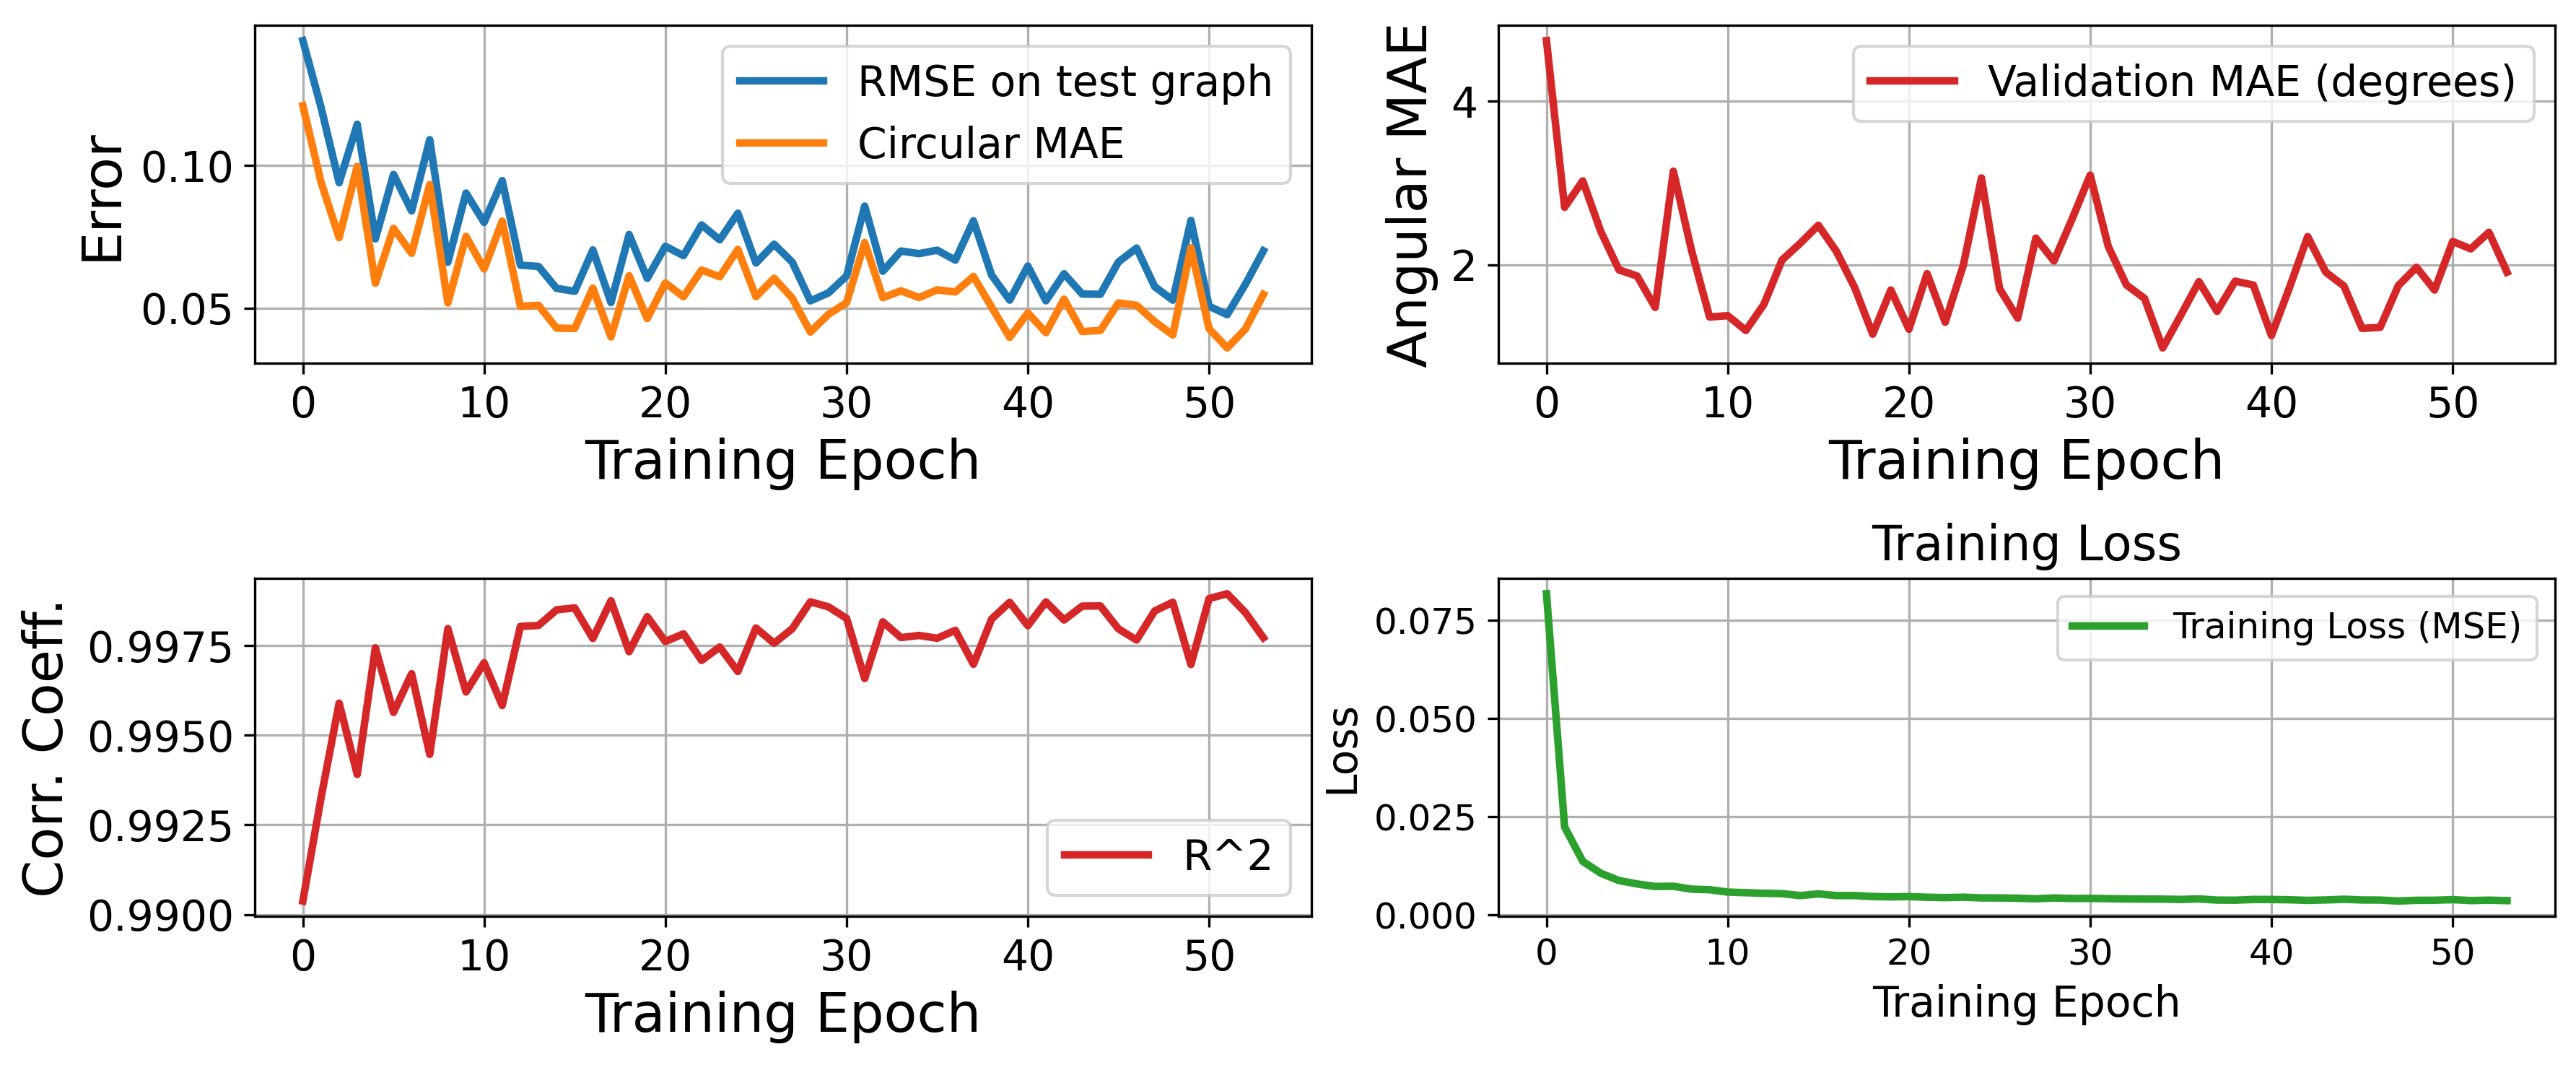

In [16]:
fig0, ax0 = plt.subplots(2, 2, figsize=(12, 5), dpi=300)

ax0[0, 0].plot(RMSE_list, label='RMSE on test graph', linewidth=2.5)
ax0[0, 0].plot(MAE_list, label='Circular MAE', linewidth=2.5)
ax0[0, 0].set_xlabel("Training Epoch", fontsize=18)
ax0[0, 0].set_ylabel("Error", fontsize=18)
ax0[0, 0].tick_params(axis="both", labelsize=14)
ax0[0, 0].legend(fontsize=14)
ax0[0, 0].grid(True)

ax0[0, 1].plot(ang_mae_val_list, label='Validation MAE (degrees)', linewidth=2.5, color='tab:red')
ax0[0, 1].set_xlabel("Training Epoch", fontsize=18)
ax0[0, 1].set_ylabel("Angular MAE", fontsize=18)
ax0[0, 1].tick_params(axis="both", labelsize=14)
ax0[0, 1].legend(fontsize=14)
ax0[0, 1].grid(True)

ax0[1, 0].plot(R2_list, label='R^2', linewidth=2.5, color='tab:red')
ax0[1, 0].set_xlabel("Training Epoch", fontsize=18)
ax0[1, 0].set_ylabel("Corr. Coeff.", fontsize=18)
ax0[1, 0].tick_params(axis="both", labelsize=14)
ax0[1, 0].legend(fontsize=14)
ax0[1, 0].grid(True)

ax0[1, 1].plot(loss_list, label='Training Loss (MSE)', linewidth=2.5, color='tab:green')
ax0[1, 1].set_title("Training Loss", fontsize=16)
ax0[1, 1].set_xlabel("Training Epoch", fontsize=14)
ax0[1, 1].set_ylabel("Loss", fontsize=14)
ax0[1, 1].tick_params(axis="both", labelsize=12)
ax0[1, 1].legend(fontsize=12)
ax0[1, 1].grid(True)
fig0.tight_layout()

plot_dir = "/mnt/e/GNN_paper/2025_IGNNK/data/results_train/figs/"
plot_file = f"training_error_curves_{file_prefix}.png"
plot_path = os.path.join(plot_dir, plot_file)
fig0.savefig(plot_path, bbox_inches='tight', dpi=300)

# print(f"Figure saved to: {plot_path}")


In [54]:
def evaluate_model_plot(true_values, predicted_values, str_title):
    """Computes evaluation metrics and plots actual vs. predicted azimuth values."""
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    r2 = r2_score(true_values, predicted_values)
    

    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    print(f"R^2 Score: {r2:.6f}")

    plt.figure(figsize=(10, 8))
    plt.scatter(true_values, predicted_values, alpha=0.6, color='blue', edgecolors='k')
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--')
    plt.xlabel("Actual Azimuth")
    plt.ylabel("Predicted Azimuth")
    plt.title(str_title)
    plt.grid(True)
    plt.show()

In [53]:
def plot_error_distribution(true_values, predicted_values, str_title):
    """
    Plots the error distribution of predicted azimuth values.

    Parameters:
        true_values (array): Ground truth azimuth values.
        predicted_values (array): Model predicted azimuth values.
    """

    circular_errors = np.array([min(abs(p - t), 180 - abs(p - t)) for p, t in zip(predicted_values, true_values)])


    plt.figure(figsize=(10, 5))
    sns.histplot(circular_errors, bins=30, kde=True, color="blue", alpha=0.7)
    plt.axvline(np.mean(circular_errors), color='red', linestyle='dashed', label=f"Mean Error: {np.mean(circular_errors):.2f}°")

    plt.xlabel("Azimuth Error in degrees")
    plt.ylabel("Frequency")
    plt.title(str_title)
    plt.legend()
    plt.grid(True)
    plt.show()

    error_data = {
        "True Azimuth": true_values,
        "Predicted Azimuth": predicted_values,
        "Absolute Error": circular_errors,
        "Corrected Circular Error": circular_errors
    }

    error_df = pd.DataFrame(error_data)

    display(error_df)

In [51]:
# o=o.T
# X_T = X_T.T
pred_cos  = o[:, 0]     # channel-0 
pred_sin  = o[:,1]      # channel-1 
PRED_AZI = decode_azimuth(pred_cos, pred_sin)
true_cos  = X_T[:,0]
true_sin  = X_T[:,1]
TRUE_AZI = decode_azimuth(true_cos, true_sin)

#############################
azi_error = np.abs(PRED_AZI - TRUE_AZI)
azi_error = np.minimum(azi_error, 180 - azi_error)
azi_error

## Identify anchor nodes: those with non-zero ground truth vectors
is_anchor = (np.abs(true_cos) + np.abs(true_sin)) > 1e-4
is_anchor 
df_out = node_info.copy()
# df_out
df_out['AZI'] = TRUE_AZI
df_out['AZI_PRED'] = PRED_AZI
df_out['ABS_ERROR_DEG'] = azi_error
df_out['IS_ANCHOR'] = is_anchor
df_out = df_out[['ID', 'LON', 'LAT', 'QUALITY', 'PLATE', 'DIST', 'AZI', 'AZI_PRED', 'ABS_ERROR_DEG']]

# save here
data_dir = f"/mnt/e/GNN_paper/2025_IGNNK/data/results_train/"
fname = f"iS_GNN_{file_prefix}.csv"
csv_path = os.path.join(data_dir, fname)
df_out.to_csv(csv_path, index=False)
print(f"Predictions saved to: {csv_path}")

Predictions saved to: /mnt/e/GNN_paper/2025_IGNNK/data/results_train/iS_GNN_ep150_bs128_lr5em04_z96_nm80_20250805_104438.csv


In [48]:
# X_T

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [0.82903755, 0.5591929 ],
       ...,
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ]])

In [50]:
# o[:,1]

array([0.        , 0.        , 0.5591929 , ..., 0.05509477, 0.04586317,
       0.06177028], dtype=float32)

In [45]:
# pred_sin

array([0.        , 0.        , 0.5591929 , ..., 0.05509477, 0.04586317,
       0.06177028], dtype=float32)

Mean Squared Error (MSE): 0.000000
Mean Absolute Error (MAE): 0.000001
R^2 Score: 1.000000


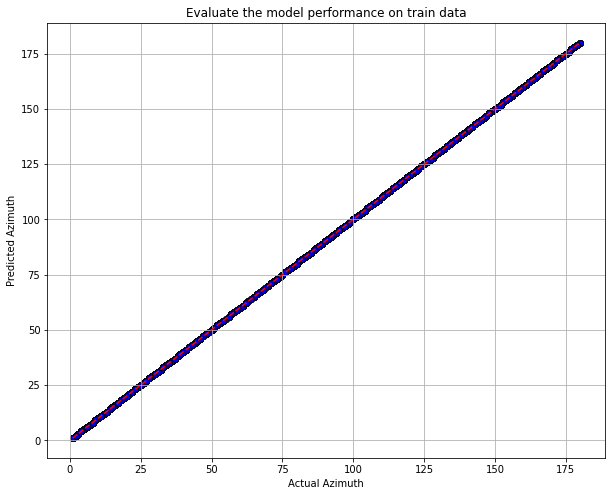

In [55]:
## Evaluate the model performance on train data
testdata_PRED_csv_path = csv_path#'/mnt/e/GNN_paper/IGNNK/data/wsm2016/gmt_plots/shmax_predictions_ep100_bs128_lr5em04_z96_nm82_20250723_133138.csv'
df_load_out = pd.read_csv(testdata_PRED_csv_path)
df_load_out = df_load_out[~(df_load_out['AZI']==0)] #removes 0 degree azimuths
evaluate_model_plot(df_load_out['AZI'], df_load_out['AZI_PRED'], "Evaluate the model performance on train data")

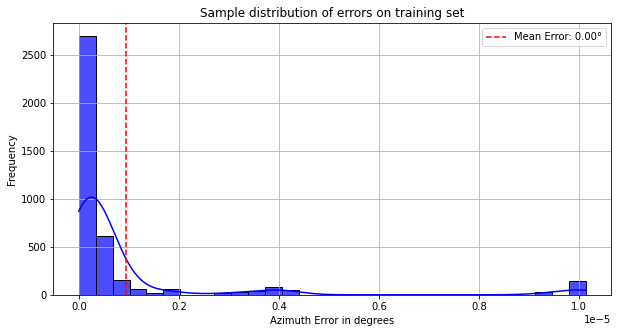

,True Azimuth,Predicted Azimuth,Absolute Error,Corrected Circular Error
2,17.000000,17.000000,2.275365e-07,2.275365e-07
3,140.000000,140.000000,1.415528e-07,1.415528e-07
4,72.000000,72.000000,3.306751e-07,3.306751e-07
5,28.000000,27.999998,1.772463e-06,1.772463e-06
6,36.000000,36.000000,1.366143e-08,1.366143e-08
...,...,...,...,...
4019,14.000001,13.999999,1.665800e-06,1.665800e-06
4020,142.000000,142.000000,1.628796e-07,1.628796e-07
4021,129.000000,129.000000,3.099998e-07,3.099998e-07
4022,138.000000,138.000000,2.991624e-08,2.991624e-08


In [56]:
plot_error_distribution(df_load_out['AZI'], df_load_out['AZI_PRED'], 'Sample distribution of errors on training set')

In [57]:
## view validation results of the 15% held-out dataset
azi_val_pred = decode_azimuth(pred_cos_val, pred_sin_val)
azi_val_true = decode_azimuth(true_cos_val, true_sin_val)
azi_val_err  = np.abs(azi_val_pred - azi_val_true)
azi_val_err  = np.minimum(azi_val_err, 180 - azi_val_err)

df_val = node_info.iloc[val_indices].copy()
df_val['AZI_TRUE'] = azi_val_true
df_val['AZI_PRED'] = azi_val_pred
df_val['AZI_ERROR'] = azi_val_err

print(df_val[['ID', 'LON', 'LAT', 'AZI_TRUE', 'AZI_PRED', 'AZI_ERROR']].head())

# 5. Save as CSV
csv_path1 = os.path.join(data_dir, f"iS_GNN_predictions_on_val_set_{file_prefix}.csv")
df_val.to_csv(csv_path1, index=False)
print(f"CSV saved to: {csv_path1}")


# now save to a GeoJSON file format
# geometry = [Point(lon, lat) for lon, lat in zip(df_val["LON"], df_val["LAT"])]
# gdf_val = gpd.GeoDataFrame(df_val, geometry=geometry, crs="EPSG:4326")
# geojson_path = os.path.join(data_dir, f"shmax_predictions_on_val_set_{file_prefix}.geojson")
# gdf_val.to_file(geojson_path, driver="GeoJSON")
# print(f"GeoJSON saved to: {geojson_path}")

             ID     LON     LAT   AZI_TRUE    AZI_PRED  AZI_ERROR
1      wsm00017  33.690  41.800   0.000000  178.661758   1.338242
13     wsm00222  23.872  39.150  66.000001   64.285683   1.714318
2277  wsm218348  36.300  37.160  11.000000    9.740688   1.259311
2281  wsm218594  37.220  37.380   7.000000    5.066995   1.933005
18     wsm00227  25.383  40.008  78.000000   77.576805   0.423195
CSV saved to: /mnt/e/GNN_paper/2025_IGNNK/data/results_train/iS_GNN_predictions_on_val_set_ep150_bs128_lr5em04_z96_nm80_20250805_104438.csv


In [58]:
df_val.shape

(603, 12)

Mean Squared Error (MSE): 206.974570
Mean Absolute Error (MAE): 3.466456
R^2 Score: 0.932601


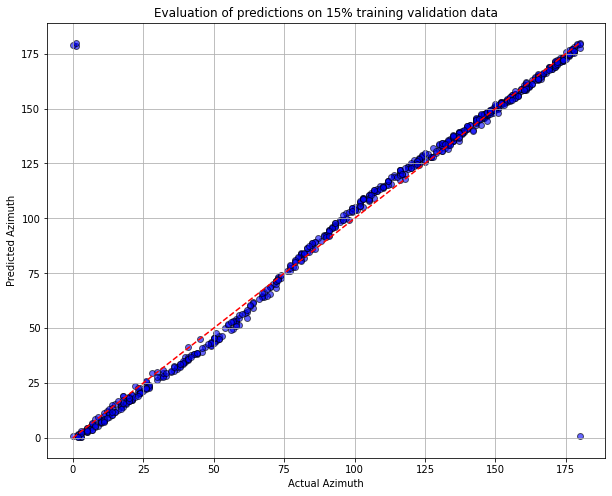

In [35]:
#check performance of predictions on the 15% held-out test data
valdata_csv_path = csv_path1 #'/mnt/e/GNN_paper/IGNNK/data/wsm2016/gmt_plots/shmax_predictions_on_val_set_ep100_bs128_lr5em04_z96_nm82_20250723_133138.csv'
# df_load_out1 = pd.read_csv(valdata_csv_path)
# df_load_out1 = df_load_out1[~(df_load_out1['AZI']>180)] # removes artificial outliers
evaluate_model_plot(df_val['AZI'], df_val['AZI_PRED'], "Evaluation of predictions on 15% training validation data")

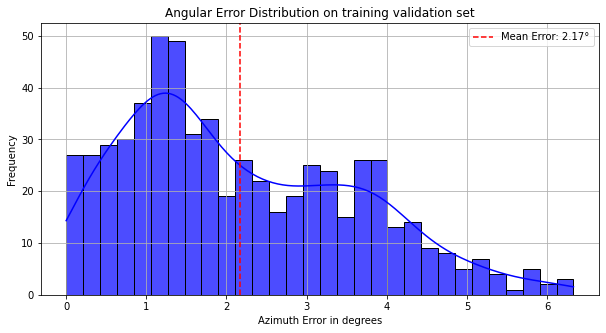

,True Azimuth,Predicted Azimuth,Absolute Error,Corrected Circular Error
1,0.0,178.661758,1.338242,1.338242
13,66.0,64.285683,1.714317,1.714317
2277,11.0,9.740688,1.259312,1.259312
2281,7.0,5.066995,1.933005,1.933005
18,78.0,77.576805,0.423195,0.423195
...,...,...,...,...
2241,54.0,50.995800,3.004200,3.004200
2244,119.0,124.834381,5.834381,5.834381
2254,66.0,64.107834,1.892166,1.892166
2257,92.0,93.392380,1.392380,1.392380


In [59]:
plot_error_distribution(df_val['AZI'], df_val['AZI_PRED'], 'Angular Error Distribution on training validation set')

In [18]:
## NOW evaluate on test data with azimuth 999 ##

(7065, 2)

In [44]:
# STmodel = torch.load('ignnk_shmax_EU_AR1_Trained_1.pth')
# # STmodel.eval()
print(type(STmodel))

<class 'basic_structure.IGNNK_ModOptionB'>


NameError: name 'X_aux2' is not defined

(7403, 2)

In [45]:
out

array([[ 0.819549  , -0.32602215,  0.5787312 , ..., -0.06479289,
        -0.08538505, -0.09659714],
       [ 0.5614221 , -0.96592796,  0.8074293 , ..., -0.17947623,
        -0.22181344, -0.21611857]], dtype=float32)

In [48]:
filtered_999_df

,ID,LON,LAT,PLATE,DIST,BOUNDARY,QUALITY,AZI,AZI_PRED,AZI_ERROR
4289,wsm13961,30.770,36.180,AT,122.0,SUB,E,0.0,138.768875,41.231125
4290,wsm39976,42.250,36.220,AR,180.0,CCB,E,0.0,95.061058,84.938942
4291,wsm39009,1.726,36.229,AF,21.0,CCB,E,0.0,135.175705,44.824295
4292,wsm24842,21.810,36.230,AS,16.0,SUB,E,0.0,134.670746,45.329254
4293,wsm40018,-9.980,36.250,AF,36.0,OCB,E,0.0,111.609138,68.390862
...,...,...,...,...,...,...,...,...,...,...
5144,wsm10260,7.017,67.067,EU,608.0,OSR,E,0.0,120.762947,59.237053
5145,wsm00040,22.195,67.493,EU,834.0,OSR,E,0.0,124.965561,55.034439
5146,wsm00384,23.230,68.740,EU,743.0,OSR,E,0.0,125.074936,54.925064
5147,wsm12450,-12.698,69.250,EU,122.0,OSR,E,0.0,124.473129,55.526871


In [50]:
# subset_df[(subset_df['QUALITY']!='E')&(subset_df['AZI']>0)]

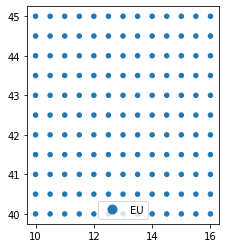

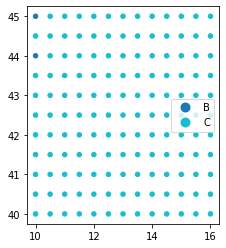

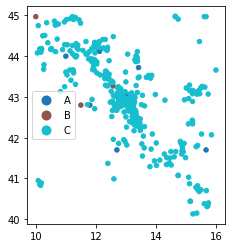

In [62]:
# anchor_data_path3 = "/mnt/e/GNN_paper/IGNNK/data/wsm2016/wsm2016_sicily.csv"
grid_gdf3 = "data/grids_train/all_grid_data_0p5r.csv"
sh_dat_3 = generate_shmax_train_data(anchor_data_path, grid_gdf3)

A3, X_target3, grid_gdf3, anchor_gdf3, _,node_info3 = load_shmax_train_data()

grid_gdf3 = grid_gdf3[df_cols]
node_info3 = node_info3[df_cols]
anchor_gdf3 = anchor_gdf3[df_cols]

grid_gdf3.plot(column='PLATE', markersize=20, legend=True)
grid_gdf3.plot(column='QUALITY', markersize=20, legend=True)
anchor_gdf3.plot(column='QUALITY', markersize=20, legend=True)
plt.show()

In [63]:
grid_gdf3.to_csv("data/grids_train/processed_grid_train_0p5r.csv", index=False)
anchor_gdf3.to_csv("data/anchors_train/processed_anchor_train_0p5r.csv", index=False)

In [64]:
node_info3[df_cols]

,ID,LON,LAT,DIST,PLATE,QUALITY,REGIME_1,AZI,geometry
86,wsm02413,13.42,43.72,542.000000,EU,A,SS,85.0,POINT (13.42000 43.72000)
110,wsm02482,12.57,43.27,477.000000,EU,B,NF,117.0,POINT (12.57000 43.27000)
290,wsm102226,12.99,43.61,521.000000,EU,C,SS,169.0,POINT (12.99000 43.61000)
308,wsm103605,14.74,44.91,684.000000,EU,C,SS,179.0,POINT (14.74000 44.91000)
385,wsm108318,11.29,44.01,549.000000,EU,C,NF,120.0,POINT (11.29000 44.01000)
...,...,...,...,...,...,...,...,...,...
4604,grid_000138,14.00,45.00,611.669217,EU,C,TF,NaN,POINT (14.00000 45.00000)
4605,grid_000139,14.50,45.00,611.670612,EU,C,TF,NaN,POINT (14.50000 45.00000)
4606,grid_000140,15.00,45.00,611.672007,EU,C,TF,NaN,POINT (15.00000 45.00000)
4607,grid_000141,15.50,45.00,611.673401,EU,C,SS,NaN,POINT (15.50000 45.00000)


In [65]:
grid_gdf3[grid_gdf3['QUALITY']=='C']

,ID,LON,LAT,DIST,PLATE,QUALITY,REGIME_1,AZI,geometry
4466,grid_000000,10.0,40.0,132.986190,EU,C,SS,NaN,POINT (10.00000 40.00000)
4467,grid_000001,10.5,40.0,115.197340,EU,C,TF,NaN,POINT (10.50000 40.00000)
4468,grid_000002,11.0,40.0,104.057058,EU,C,TF,NaN,POINT (11.00000 40.00000)
4469,grid_000003,11.5,40.0,103.433218,EU,C,TF,NaN,POINT (11.50000 40.00000)
4470,grid_000004,12.0,40.0,111.328208,EU,C,TF,NaN,POINT (12.00000 40.00000)
...,...,...,...,...,...,...,...,...,...
4604,grid_000138,14.0,45.0,611.669217,EU,C,TF,NaN,POINT (14.00000 45.00000)
4605,grid_000139,14.5,45.0,611.670612,EU,C,TF,NaN,POINT (14.50000 45.00000)
4606,grid_000140,15.0,45.0,611.672007,EU,C,TF,NaN,POINT (15.00000 45.00000)
4607,grid_000141,15.5,45.0,611.673401,EU,C,SS,NaN,POINT (15.50000 45.00000)


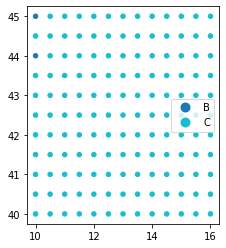

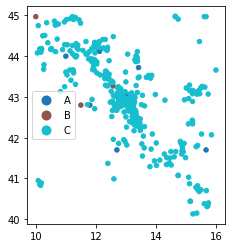

In [66]:
grid_gdf3.plot(column='QUALITY', markersize=20, legend=True)
anchor_gdf3.plot(column='QUALITY', markersize=20, legend=True)

In [68]:
# max_depth3 = node_info3['DEPTH'].max()
max_dist3  = node_info3['DIST'].max()

# depth_feat3 = node_info3['DEPTH'].fillna(0) / max_depth3
dist_feat3  = node_info3['DIST'].fillna(0) / max_dist3

# Load encoder
with open("data/num_array_files/ppb_encoder.pkl", "rb") as f:
    encoder = pickle.load(f)
# Use it to transform the new region
cat_features3 = encoder.transform(node_info3[["PLATE", 'QUALITY' ,"REGIME_1"]])

X_aux3 = np.column_stack([dist_feat3, cat_features3])  # shape (N , p)

X_total3 = np.concatenate([X_target3, X_aux3], axis=-1)   # (N , h_total)

print(f" Prepared input: {X_total3.shape[0]} nodes x {X_total3.shape[1]} features")


inp_3 = torch.from_numpy(X_total3.T.astype('float32')[np.newaxis])
A_q_3 = torch.from_numpy(calculate_random_walk_matrix(A3).T.astype('float32'))
A_h_3 = torch.from_numpy(calculate_random_walk_matrix(A3.T).T.astype('float32'))

with torch.no_grad():
    out3 = STmodel(inp_3, A_q_3, A_h_3)[0].cpu().numpy()   # shape (2 , N_test)

pred_cos3 = out3[0]
pred_sin3 = out3[1]
true_cos3 = X_target3[:, 0]
true_sin3 = X_target3[:, 1]

azi_pred3 = decode_azimuth(pred_cos3, pred_sin3)
azi_true3 = decode_azimuth(true_cos3, true_sin3)
azi_err3  = np.minimum(np.abs(azi_pred3 - azi_true3), 180 - np.abs(azi_pred3 - azi_true3))
mae_deg3  = azi_err3.mean()

print(f"Angular MAE at 0.5 degree resolution: {mae_deg3:.2f}")

 Prepared input: 661 nodes x 16 features
Angular MAE at 0.5 degree resolution: 8.69


In [73]:
df_test3 = node_info3.copy()
df_test3['AZI'] = azi_true3
df_test3['AZI_PRED'] = azi_pred3
df_test3['AZI_ERROR'] = azi_err3
df_test3 = df_test3[['ID', 'LON','LAT','geometry','PLATE', 'REGIME_1' ,'DIST', 'QUALITY' ,'AZI' ,'AZI_PRED','AZI_ERROR']]

# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# results_dir = "data/grids_train/"
fname0 = f"GNN_grid_0p5r_results.csv"
fname1 = f"GNN_anchor_0p5r_results.csv"
csv_path0 = os.path.join(data_dir, fname0)
csv_path1 = os.path.join(data_dir, fname1)
df_test3[df_test3["ID"].str.startswith("grid_")].to_csv(csv_path0, index=False)
df_test3[df_test3["ID"].str.startswith("wsm")].to_csv(csv_path1, index=False)

/mnt/e/GNN_paper/2025_IGNNK/data/results_train/


In [74]:
df_test3[df_test3["ID"].str.startswith("grid_")]


,ID,LON,LAT,geometry,PLATE,REGIME_1,DIST,QUALITY,AZI,AZI_PRED,AZI_ERROR
4466,grid_000000,10.0,40.0,POINT (10.00000 40.00000),EU,SS,132.986190,C,0.0,41.834030,41.834030
4467,grid_000001,10.5,40.0,POINT (10.50000 40.00000),EU,TF,115.197340,C,0.0,17.884205,17.884205
4468,grid_000002,11.0,40.0,POINT (11.00000 40.00000),EU,TF,104.057058,C,0.0,3.443515,3.443515
4469,grid_000003,11.5,40.0,POINT (11.50000 40.00000),EU,TF,103.433218,C,0.0,160.122452,19.877548
4470,grid_000004,12.0,40.0,POINT (12.00000 40.00000),EU,TF,111.328208,C,0.0,149.197525,30.802475
...,...,...,...,...,...,...,...,...,...,...,...
4604,grid_000138,14.0,45.0,POINT (14.00000 45.00000),EU,TF,611.669217,C,0.0,118.133987,61.866013
4605,grid_000139,14.5,45.0,POINT (14.50000 45.00000),EU,TF,611.670612,C,0.0,113.783363,66.216637
4606,grid_000140,15.0,45.0,POINT (15.00000 45.00000),EU,TF,611.672007,C,0.0,110.416481,69.583519
4607,grid_000141,15.5,45.0,POINT (15.50000 45.00000),EU,SS,611.673401,C,0.0,109.661797,70.338203


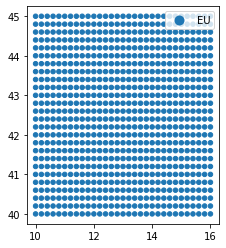

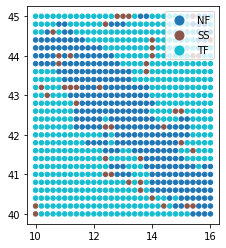

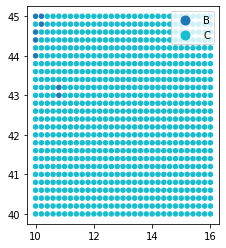

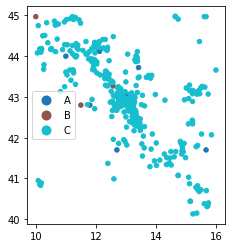

,ID,LON,LAT,DIST,PLATE,QUALITY,REGIME_1,AZI,geometry
86,wsm02413,13.42,43.72,542.000000,EU,A,SS,85.0,POINT (13.42000 43.72000)
110,wsm02482,12.57,43.27,477.000000,EU,B,NF,117.0,POINT (12.57000 43.27000)
290,wsm102226,12.99,43.61,521.000000,EU,C,SS,169.0,POINT (12.99000 43.61000)
308,wsm103605,14.74,44.91,684.000000,EU,C,SS,179.0,POINT (14.74000 44.91000)
385,wsm108318,11.29,44.01,549.000000,EU,C,NF,120.0,POINT (11.29000 44.01000)
...,...,...,...,...,...,...,...,...,...
5267,grid_000801,15.20,45.00,611.672564,EU,C,TF,NaN,POINT (15.20000 45.00000)
5268,grid_000802,15.40,45.00,611.673122,EU,C,SS,NaN,POINT (15.40000 45.00000)
5269,grid_000803,15.60,45.00,611.673680,EU,C,NF,NaN,POINT (15.60000 45.00000)
5270,grid_000804,15.80,45.00,611.674238,EU,C,NF,NaN,POINT (15.80000 45.00000)


In [75]:

grid_path4 = "data/grids_train/all_grid_data_0p2r.csv"
sh_dat_4 = generate_shmax_train_data(anchor_data_path, grid_path4)

A4, X_target4, grid_gdf4, anchor_gdf4, _,node_info4 = load_shmax_train_data()

# plates_gdf.boundary.plot(edgecolor='black')
grid_gdf4 = grid_gdf4[df_cols]
anchor_gdf4 = anchor_gdf4[df_cols]
node_info4 = node_info4[df_cols]

grid_gdf4.plot(column='PLATE', markersize=20, legend=True)
grid_gdf4.plot(column='REGIME_1', markersize=20, legend=True)
grid_gdf4.plot(column='QUALITY', markersize=20, legend=True)
anchor_gdf4.plot(column='QUALITY', markersize=20, legend=True)
plt.show()

node_info4 

In [87]:
anchor_gdf4

,ID,LON,LAT,DEPTH,DIST,PLATE,QUALITY,BOUNDARY,REGIME,AZI,geometry
2154,wsm39419,15.910,40.230,10.60,202.0,EU,D,SUB,NF,112.0,POINT (15.91000 40.23000)
2196,wsm38427,15.905,40.316,0.95,210.0,EU,B,SUB,U,132.0,POINT (15.90500 40.31600)
2199,wsm38321,15.990,40.325,2.08,212.0,EU,D,OTF,U,126.0,POINT (15.99000 40.32500)
2201,wsm38415,15.896,40.327,2.93,210.0,EU,B,SUB,U,162.0,POINT (15.89600 40.32700)
2202,wsm38401,15.937,40.327,3.80,212.0,EU,C,SUB,U,133.0,POINT (15.93700 40.32700)
...,...,...,...,...,...,...,...,...,...,...,...
4117,wsm30965,11.070,44.920,10.00,650.0,EU,C,SUB,TF,11.0,POINT (11.07000 44.92000)
4118,wsm41808,11.120,44.920,7.50,650.0,EU,C,SUB,TF,24.0,POINT (11.12000 44.92000)
4121,wsm41879,10.900,44.930,17.00,652.0,EU,C,SUB,SS,86.0,POINT (10.90000 44.93000)
4141,wsm37659,10.000,44.970,10.00,663.0,EU,B,SUB,SS,49.0,POINT (10.00000 44.97000)


In [80]:
grid_gdf4

,ID,LON,LAT,DEPTH,DIST,PLATE,QUALITY,BOUNDARY,REGIME,AZI,geometry
4652,grid_000000,10.0,40.0,0.0,132.986190,EU,C,CCB,TF,NaN,POINT (10.00000 40.00000)
4653,grid_000001,10.5,40.0,0.0,115.197340,EU,C,CCB,TF,NaN,POINT (10.50000 40.00000)
4654,grid_000002,11.0,40.0,0.0,104.057058,EU,C,CTF,SS,NaN,POINT (11.00000 40.00000)
4655,grid_000003,11.5,40.0,0.0,103.433218,EU,C,CCB,TF,NaN,POINT (11.50000 40.00000)
4656,grid_000004,12.0,40.0,0.0,111.328208,EU,C,CCB,TF,NaN,POINT (12.00000 40.00000)
...,...,...,...,...,...,...,...,...,...,...,...
4790,grid_000138,14.0,45.0,0.0,611.669217,EU,C,CCB,TF,NaN,POINT (14.00000 45.00000)
4791,grid_000139,14.5,45.0,0.0,611.670612,EU,C,CRB,NF,NaN,POINT (14.50000 45.00000)
4792,grid_000140,15.0,45.0,0.0,611.672007,EU,C,CTF,SS,NaN,POINT (15.00000 45.00000)
4793,grid_000141,15.5,45.0,0.0,611.673401,EU,C,CRB,NF,NaN,POINT (15.50000 45.00000)


In [77]:
# max_depth4 = node_info4['DEPTH'].max()
max_dist4  = node_info4['DIST'].max()

# depth_feat4 = node_info4['DEPTH'].fillna(0) / max_depth4
dist_feat4  = node_info4['DIST'].fillna(0) / max_dist4

# Load encoder
with open("data/num_array_files/ppb_encoder.pkl", "rb") as f:
    encoder = pickle.load(f)
# Use it to transform the new region
cat_features4 = encoder.transform(node_info4[["PLATE", 'QUALITY','REGIME_1']])

X_aux4 = np.column_stack([dist_feat4, cat_features4])  # shape (N , p)

X_total4 = np.concatenate([X_target4, X_aux4], axis=-1)   # (N , h_total)

print(f" Prepared input: {X_total4.shape[0]} nodes x {X_total4.shape[1]} features")

inp_4 = torch.from_numpy(X_total4.T.astype('float32')[np.newaxis])
A_q_4 = torch.from_numpy(calculate_random_walk_matrix(A4).T.astype('float32'))
A_h_4 = torch.from_numpy(calculate_random_walk_matrix(A4.T).T.astype('float32'))

with torch.no_grad():
    out4 = STmodel(inp_4, A_q_4, A_h_4)[0].cpu().numpy()   # shape (2 , N_test)

pred_cos4 = out4[0]
pred_sin4 = out4[1]
true_cos4 = X_target4[:, 0]
true_sin4 = X_target4[:, 1]

azi_pred4 = decode_azimuth(pred_cos4, pred_sin4)
azi_true4 = decode_azimuth(true_cos4, true_sin4)
azi_err4  = np.minimum(np.abs(azi_pred4 - azi_true4), 180 - np.abs(azi_pred4 - azi_true4))
mae_deg4  = azi_err4.mean()

print(f"Angular MAE at 0.2 grid res: {mae_deg4:.2f}")

 Prepared input: 1324 nodes x 16 features
Angular MAE at 0.2 grid res: 19.22


In [79]:
df_test4 = node_info4.copy()
df_test4['AZI'] = azi_true4
df_test4['AZI_PRED'] = azi_pred4
df_test4['AZI_ERROR'] = azi_err4
df_test4 = df_test4[['ID', 'LON', 'LAT', 'geometry','PLATE','REGIME_1','QUALITY','DIST','AZI' ,'AZI_PRED','AZI_ERROR']]

# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
fname0 = f"GNN_grid_0p2r_R1_result.csv"
fname1 = f"GNN_anchor_0p2r_R1_result.csv"
csv_path0 = os.path.join(data_dir, fname0)
csv_path1 = os.path.join(data_dir, fname1)
df_test4[df_test4["ID"].str.startswith("grid_")].to_csv(csv_path0, index=False)
df_test4[df_test4["ID"].str.startswith("wsm")].to_csv(csv_path1, index=False)

In [80]:
df_test4[df_test4["ID"].str.startswith("grid_")]

,ID,LON,LAT,geometry,PLATE,REGIME_1,QUALITY,DIST,AZI,AZI_PRED,AZI_ERROR
4466,grid_000000,10.0,40.0,POINT (10.00000 40.00000),EU,SS,C,132.986190,0.0,61.411076,61.411076
4467,grid_000001,10.2,40.0,POINT (10.20000 40.00000),EU,TF,C,124.054855,0.0,54.688843,54.688843
4468,grid_000002,10.4,40.0,POINT (10.40000 40.00000),EU,TF,C,117.596152,0.0,59.319920,59.319920
4469,grid_000003,10.6,40.0,POINT (10.60000 40.00000),EU,TF,C,113.102797,0.0,68.457108,68.457108
4470,grid_000004,10.8,40.0,POINT (10.80000 40.00000),EU,TF,C,107.729624,0.0,80.074867,80.074867
...,...,...,...,...,...,...,...,...,...,...,...
5267,grid_000801,15.2,45.0,POINT (15.20000 45.00000),EU,TF,C,611.672564,0.0,127.495773,52.504227
5268,grid_000802,15.4,45.0,POINT (15.40000 45.00000),EU,SS,C,611.673122,0.0,117.154694,62.845306
5269,grid_000803,15.6,45.0,POINT (15.60000 45.00000),EU,NF,C,611.673680,0.0,147.393066,32.606934
5270,grid_000804,15.8,45.0,POINT (15.80000 45.00000),EU,NF,C,611.674238,0.0,149.802429,30.197571


Before reassignment: 0 / 806
After reassignment: 0 / 806


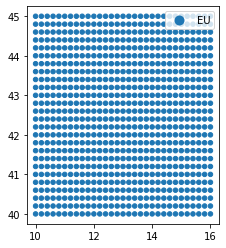

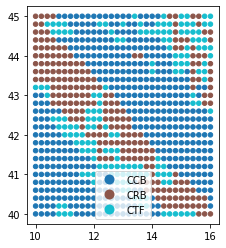

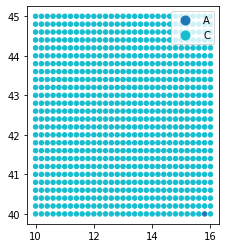

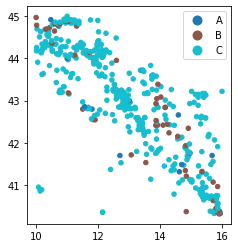

In [83]:
# anchor_data_path5 = "/mnt/e/GNN_paper/IGNNK/data/wsm2016/wsm2016_sicily.csv"
grid_gdf_path5 = "/mnt/e/GNN_paper/IGNNK/data/wsm2016/DATI_csv/grid_D0_2.csv"

sh_dat_5 = generate_shmax_train_data(anchor_data_path, grid_gdf_path5)

A5, X_target5, grid_gdf5, anchor_gdf5, _ ,node_info5 = load_shmax_train_data()

grid_gdf5 = grid_gdf5[df_cols]
anchor_gdf5 = anchor_gdf5[df_cols]
node_info5 = node_info5[df_cols]

# plates_gdf.boundary.plot(edgecolor='black')
grid_gdf5.plot(column='PLATE', markersize=20, legend=True)
grid_gdf5.plot(column='REGIME_1', markersize=20, legend=True)
grid_gdf5.plot(column='QUALITY', markersize=20, legend=True)
anchor_gdf5.plot(column='QUALITY', markersize=20, legend=True)
plt.show()

In [98]:
node_info5

,ID,LON,LAT,DEPTH,DIST,PLATE,QUALITY,BOUNDARY,REGIME,AZI,geometry
2154,wsm39419,15.910,40.230,10.60,202.000000,EU,D,SUB,NF,112.0,POINT (15.91000 40.23000)
2196,wsm38427,15.905,40.316,0.95,210.000000,EU,B,SUB,U,132.0,POINT (15.90500 40.31600)
2199,wsm38321,15.990,40.325,2.08,212.000000,EU,D,OTF,U,126.0,POINT (15.99000 40.32500)
2201,wsm38415,15.896,40.327,2.93,210.000000,EU,B,SUB,U,162.0,POINT (15.89600 40.32700)
2202,wsm38401,15.937,40.327,3.80,212.000000,EU,C,SUB,U,133.0,POINT (15.93700 40.32700)
...,...,...,...,...,...,...,...,...,...,...,...
7816,grid_000801,15.200,45.000,0.00,611.672564,EU,C,CTF,SS,NaN,POINT (15.20000 45.00000)
7817,grid_000802,15.400,45.000,0.00,611.673122,EU,C,CRB,NF,NaN,POINT (15.40000 45.00000)
7818,grid_000803,15.600,45.000,0.00,611.673680,EU,C,CRB,NF,NaN,POINT (15.60000 45.00000)
7819,grid_000804,15.800,45.000,0.00,611.674238,EU,C,CTF,SS,NaN,POINT (15.80000 45.00000)


In [99]:
grid_gdf5

,ID,LON,LAT,DEPTH,DIST,PLATE,QUALITY,BOUNDARY,REGIME,AZI,geometry
7015,grid_000000,10.0,40.0,0.0,132.986190,EU,C,CCB,TF,NaN,POINT (10.00000 40.00000)
7016,grid_000001,10.2,40.0,0.0,124.054855,EU,C,CCB,TF,NaN,POINT (10.20000 40.00000)
7017,grid_000002,10.4,40.0,0.0,117.596152,EU,C,CCB,TF,NaN,POINT (10.40000 40.00000)
7018,grid_000003,10.6,40.0,0.0,113.102797,EU,C,CCB,TF,NaN,POINT (10.60000 40.00000)
7019,grid_000004,10.8,40.0,0.0,107.729624,EU,C,CTF,SS,NaN,POINT (10.80000 40.00000)
...,...,...,...,...,...,...,...,...,...,...,...
7816,grid_000801,15.2,45.0,0.0,611.672564,EU,C,CTF,SS,NaN,POINT (15.20000 45.00000)
7817,grid_000802,15.4,45.0,0.0,611.673122,EU,C,CRB,NF,NaN,POINT (15.40000 45.00000)
7818,grid_000803,15.6,45.0,0.0,611.673680,EU,C,CRB,NF,NaN,POINT (15.60000 45.00000)
7819,grid_000804,15.8,45.0,0.0,611.674238,EU,C,CTF,SS,NaN,POINT (15.80000 45.00000)


In [84]:
# max_depth5 = node_info5['DEPTH'].max()
max_dist5  = node_info5['DIST'].max()

# depth_feat5 = node_info5['DEPTH'].fillna(0) / max_depth5
dist_feat5  = node_info5['DIST'].fillna(0) / max_dist5

# Load encoder
with open("data/wsm2016/ppb_encoder.pkl", "rb") as f:
    encoder = pickle.load(f)
# Use it to transform the new region
cat_features5 = encoder.transform(node_info5[["PLATE", 'QUALITY','BOUNDARY']])

X_aux5 = np.column_stack([dist_feat5, cat_features5])  # shape (N , p)

X_total5 = np.concatenate([X_target5, X_aux5], axis=-1)   # (N , h_total)

print(f" Prepared input: {X_total5.shape[0]} nodes x {X_total5.shape[1]} features")

inp_5 = torch.from_numpy(X_total5.T.astype('float32')[np.newaxis])
A_q_5 = torch.from_numpy(calculate_random_walk_matrix(A5).T.astype('float32'))
A_h_5 = torch.from_numpy(calculate_random_walk_matrix(A5.T).T.astype('float32'))

with torch.no_grad():
    out5 = STmodel(inp_5, A_q_5, A_h_5)[0].cpu().numpy()   # shape (2 , N_test)

pred_cos5 = out5[0]
pred_sin5 = out5[1]
true_cos5 = X_target5[:, 0]
true_sin5 = X_target5[:, 1]

azi_pred5 = decode_azimuth(pred_cos5, pred_sin5)
azi_true5 = decode_azimuth(true_cos5, true_sin5)
azi_err5  = np.minimum(np.abs(azi_pred5 - azi_true5), 180 - np.abs(azi_pred5 - azi_true5))
mae_deg5  = azi_err5.mean()

print(f"Angular MAE at 0.2 res in CA Italy: {mae_deg5:.2f}")

df_test5 = node_info5.copy()
df_test5['AZI'] = azi_true5
df_test5['AZI_PRED'] = azi_pred5
df_test5['AZI_ERROR'] = azi_err5
df_test5 = df_test5[['ID', 'LON', 'LAT','geometry','PLATE', 'BOUNDARY', 'QUALITY' ,'DIST','AZI' ,'AZI_PRED','AZI_ERROR']]

# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
fname = f"shmax_interpolations_GNN_g1.0_SICILY_{file_prefix}.csv"
csv_path = os.path.join(data_dir, fname)
df_test5.to_csv(csv_path, index=False)

 Prepared input: 1310 nodes x 18 features
Angular MAE at 0.2 res in CA Italy: 20.39


In [85]:
# df_test5 = node_info5.copy()
# df_test5['AZI'] = azi_true5
# df_test5['AZI_PRED'] = azi_pred5
# df_test5['AZI_ERROR'] = azi_err5
# df_test5 = df_test5[['ID', 'LON', 'LAT', 'geometry','PLATE','BOUNDARY','QUALITY','DIST','AZI' ,'AZI_PRED','AZI_ERROR']]

# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
fname0 = f"GNN_grid_ONLY_g0.2_{file_prefix}.csv"
fname1 = f"GNN_anchor_ONLY_g0.2_{file_prefix}.csv"
csv_path0 = os.path.join(data_dir, fname0)
csv_path1 = os.path.join(data_dir, fname1)
df_test5[df_test5["ID"].str.startswith("grid_")].to_csv(csv_path0, index=False)
df_test5[df_test5["ID"].str.startswith("wsm")].to_csv(csv_path1, index=False)

In [81]:
# ls -lthr data/wsm2016/

Before reassignment: 0 / 1176
After reassignment: 0 / 904


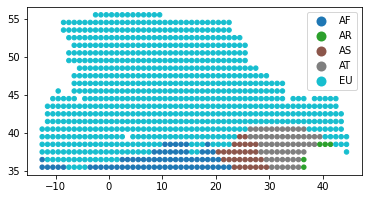

In [87]:
# anchor_data_path6 = "/mnt/e/GNN_paper/IGNNK/data/wsm2016/wsm2016_sicily.csv"
grid_spec_path6 = "/mnt/e/GNN_paper/IGNNK/data/wsm2016/DATI_csv/training_grid.csv"
sh_dat_5 = generate_shmax_train_data(anchor_data_path, grid_spec_path6)

A6, X_target6, grid_gdf6, anchor_gdf6, _,node_info6 = load_shmax_train_data()

grid_gdf6 = grid_gdf6[df_cols]
anchor_gdf6 = anchor_gdf6[df_cols]
node_info6 = node_info6[df_cols]

# plates_gdf.boundary.plot(edgecolor='black')
grid_gdf6.plot(column='PLATE', markersize=20, legend=True)
plt.show()

In [88]:
grid_gdf6.shape

(904, 11)

In [89]:
node_info6.shape

(5193, 11)

In [91]:
# max_depth6 = node_info6['DEPTH'].max()
max_dist6  = node_info6['DIST'].max()

# depth_feat6 = node_info6['DEPTH'].fillna(0) / max_depth6
dist_feat6  = node_info6['DIST'].fillna(0) / max_dist6

# Load encoder
with open("data/wsm2016/ppb_encoder.pkl", "rb") as f:
    encoder = pickle.load(f)
# Use it to transform the new region
cat_features6 = encoder.transform(node_info6[["PLATE",'QUALITY','BOUNDARY']])

X_aux6 = np.column_stack([dist_feat6, cat_features6])  # shape (N , p)

X_total6 = np.concatenate([X_target6, X_aux6], axis=-1)   # (N , h_total)

print(f" Prepared input: {X_total6.shape[0]} nodes x {X_total6.shape[1]} features")

inp_6 = torch.from_numpy(X_total6.T.astype('float32')[np.newaxis])
A_q_6 = torch.from_numpy(calculate_random_walk_matrix(A6).T.astype('float32'))
A_h_6 = torch.from_numpy(calculate_random_walk_matrix(A6.T).T.astype('float32'))

with torch.no_grad():
    out6 = STmodel(inp_6, A_q_6, A_h_6)[0].cpu().numpy()   # shape (2 , N_test)

pred_cos6 = out6[0]
pred_sin6 = out6[1]
true_cos6 = X_target6[:, 0]
true_sin6 = X_target6[:, 1]

azi_pred6 = decode_azimuth(pred_cos6, pred_sin6)
azi_true6 = decode_azimuth(true_cos6, true_sin6)
azi_err6  = np.minimum(np.abs(azi_pred6 - azi_true6), 180 - np.abs(azi_pred6 - azi_true6))
mae_deg6  = azi_err6.mean()

print(f"Angular MAE on EU Area: {mae_deg6:.2f}")

df_test6 = node_info6.copy()
df_test6['AZI'] = azi_true6
df_test6['AZI_PRED'] = azi_pred6
df_test6['AZI_ERROR'] = azi_err6
df_test6 = df_test6[['ID', 'LON', 'LAT','geometry','PLATE', 'BOUNDARY' ,'QUALITY' ,'DIST','AZI' ,'AZI_PRED','AZI_ERROR']]

# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
fname = f"/mnt/e/GNN_paper/IGNNK/data/wsm2016/gmt_plots/NEW_shmax_interpolations_GNN_g1.0_EU_{file_prefix}.csv"
csv_path = os.path.join(data_dir, fname)
df_test6.to_csv(csv_path, index=False)

 Prepared input: 5193 nodes x 18 features
Angular MAE on EU Area: 7.44


In [144]:
out6.shape

(2, 250)

In [92]:
# df_test6 = node_info6.copy()
# df_test4['AZI'] = azi_true4
# df_test4['AZI_PRED'] = azi_pred4
# df_test4['AZI_ERROR'] = azi_err4
# df_test4 = df_test4[['ID', 'LON', 'LAT', 'geometry','PLATE','BOUNDARY','QUALITY','DIST','AZI' ,'AZI_PRED','AZI_ERROR']]

# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
fname0 = f"/mnt/e/GNN_paper/IGNNK/data/wsm2016/gmt_plots/GNN_grid_ONLY_GNN_g1.0_{file_prefix}.csv"
fname1 = f"/mnt/e/GNN_paper/IGNNK/data/wsm2016/gmt_plots/GNN_anchor_ONLY_GNN_g1.0_{file_prefix}.csv"
csv_path0 = os.path.join(data_dir, fname0)
csv_path1 = os.path.join(data_dir, fname1)
df_test6[df_test6["ID"].str.startswith("grid_")].to_csv(csv_path0, index=False)
df_test6[df_test6["ID"].str.startswith("wsm")].to_csv(csv_path1, index=False)

In [145]:
node_info6.shape

(250, 23)

In [149]:
df_test6.shape

(250, 10)

In [150]:
# df_test6[df_test6['AZI']==0].to_csv('/mnt/e/GNN_paper/IGNNK/data/wsm2016/gmt_plots/POSTER-AI-DAY/NEW_GRID_GNN_INTERPOLATIONS.csv', index=False)

In [151]:
# df_test6[df_test6['AZI']>0].to_csv('/mnt/e/GNN_paper/IGNNK/data/wsm2016/gmt_plots/POSTER-AI-DAY/NEW_ANCHOR_GNN_INTERPOLATIONS.csv', index=False)